In [1]:
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
## make plots bigger
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# models
from tbats import TBATS
from prophet import Prophet
from pmdarima import auto_arima

from scipy import stats

from scipy.special import inv_boxcox


def plot_results(y_to_train,
                 y_to_test, y_forecast,
                 plot_conf_int=True,
                 left_bound=None, right_bound=None):

    plt.plot(y_to_train, label='train')
    plt.plot(y_to_test, label='test')
    plt.plot(y_to_test.index, y_forecast, label='prediction')

    if plot_conf_int:
        plt.fill_between(y_to_test.index,
                         left_bound, right_bound,
                         alpha=0.23, color='grey',
                         label='intervals')
    plt.legend()
    plt.show()

## Prophet, SARIMAX, TBATS — модели для предсказания временных рядов

### 1. Задача

Рассмотрим [датасет](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview) с kaggle с соревнования по прогнозированию спроса на товары.

In [2]:
data = pd.read_csv('train time series.csv', parse_dates=['date'])
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
store, item = 1,1
data = data[(data['store'] == store) & (data['item'] == item)]
data = data.set_index('date')
data = data['sales']

In [7]:
data

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
              ..
2017-12-27    14
2017-12-28    19
2017-12-29    15
2017-12-30    27
2017-12-31    23
Name: sales, Length: 1826, dtype: int64

### 2. Данные
Разделим данные на train и test. test — данные за последний год.

In [9]:
test_size = 365
data_train = data.iloc[: -test_size]
data_test  = data.iloc[-test_size:]

Визуализируем данные.

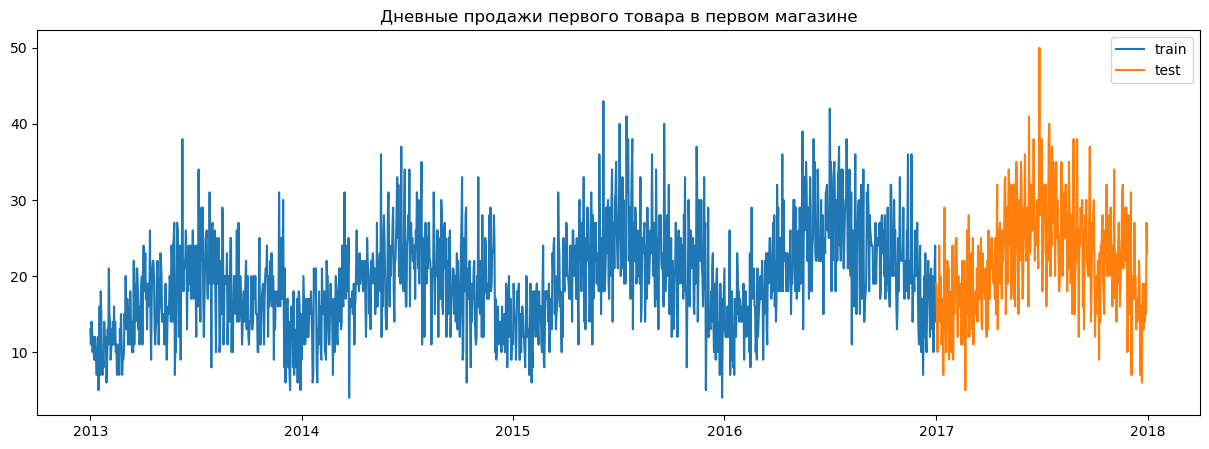

In [11]:
plt.figure(figsize=(15, 5))

plt.title('Дневные продажи первого товара в первом магазине')

plt.plot(data_train, label='train')
plt.plot(data_test, label='test')
plt.legend()

Некоторая недельная сезонность есть.

### 3. Метрики
Зададим метрики качества моделей: MSE, MAE, MAPE. Зададим функцию, которая будет вычислять метрики качества моделей и записывать их в таблицу.


- MAPE (Mean Absolute Percentage Error) поможет оценить, насколько близки прогнозы к фактическим значениям в процентном соотношении.
- 	MSE (Mean Squared Error) — для измерения среднеквадратичной ошибки между прогнозами и фактическими значениями. Это поможет понять среднюю ошибку прогноза в квадрате.
- 	MAE (Mean Absolute Error) — для оценки средней абсолютной ошибки между прогнозами и реальными значениями. Хорошо интерпретируется и проста в использовании.

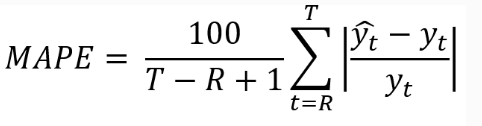

In [209]:
# MAPE
def mean_absolute_percentage_error1(y_true, y_pred) -> float:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [211]:
def add_method_comparison(method: str, y_true, y_forecast, compare_table=None) -> pd.DataFrame:
    result_row = {
        'method': method,
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "MAPE": mean_absolute_percentage_error1(y_true=y_true, y_pred=y_forecast)
    }

    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table['method']):
            compare_table = compare_table[compare_table['method'] != method]

        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table



### 4. Prophet

###4.1. Prophet

Prophet — модель для предсказания временных рядов, разработанная «Фейсбуком»*.

*Деятельность компании Meta Platforms Inc., которой принадлежит указаная соцсеть и сервис, признана экстремистской и запрещена на территории РФ.

In [17]:
prophet_train_df = pd.DataFrame(data_train)

prophet_train_df.columns = ['y']
prophet_train_df['ds'] = prophet_train_df.index

In [19]:
prophet_train_df

,y,ds
date,,
2013-01-01,13,2013-01-01
2013-01-02,11,2013-01-02
2013-01-03,14,2013-01-03
2013-01-04,13,2013-01-04
2013-01-05,10,2013-01-05
...,...,...
2016-12-27,10,2016-12-27
2016-12-28,16,2016-12-28
2016-12-29,21,2016-12-29


In [21]:
prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(prophet_train_df)

future = prophet_model.make_future_dataframe(
    periods=test_size, include_history=False
)

y_prophet_forecast = prophet_model.predict(future)

08:15:28 - cmdstanpy - INFO - Chain [1] start processing
08:15:28 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
y_prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,22.656367,12.006091,29.567568,22.656367,22.656367,-1.504747,-1.504747,-1.504747,3.723810,3.723810,3.723810,-5.228557,-5.228557,-5.228557,0.0,0.0,0.0,21.151621
1,2017-01-02,22.660412,3.950885,20.937309,22.660412,22.660412,-9.438711,-9.438711,-9.438711,-4.232954,-4.232954,-4.232954,-5.205757,-5.205757,-5.205757,0.0,0.0,0.0,13.221701
2,2017-01-03,22.664457,7.482160,24.708118,22.664457,22.664463,-6.836088,-6.836088,-6.836088,-1.636037,-1.636037,-1.636037,-5.200051,-5.200051,-5.200051,0.0,0.0,0.0,15.828369
3,2017-01-04,22.668502,8.062292,24.969627,22.668502,22.668537,-6.324862,-6.324862,-6.324862,-1.114510,-1.114510,-1.114510,-5.210352,-5.210352,-5.210352,0.0,0.0,0.0,16.343640
4,2017-01-05,22.672547,8.671197,24.726508,22.672542,22.672598,-5.942896,-5.942896,-5.942896,-0.707795,-0.707795,-0.707795,-5.235101,-5.235101,-5.235101,0.0,0.0,0.0,16.729651


Модель для каждой даты раскладывает своё предсказание на компоненты.

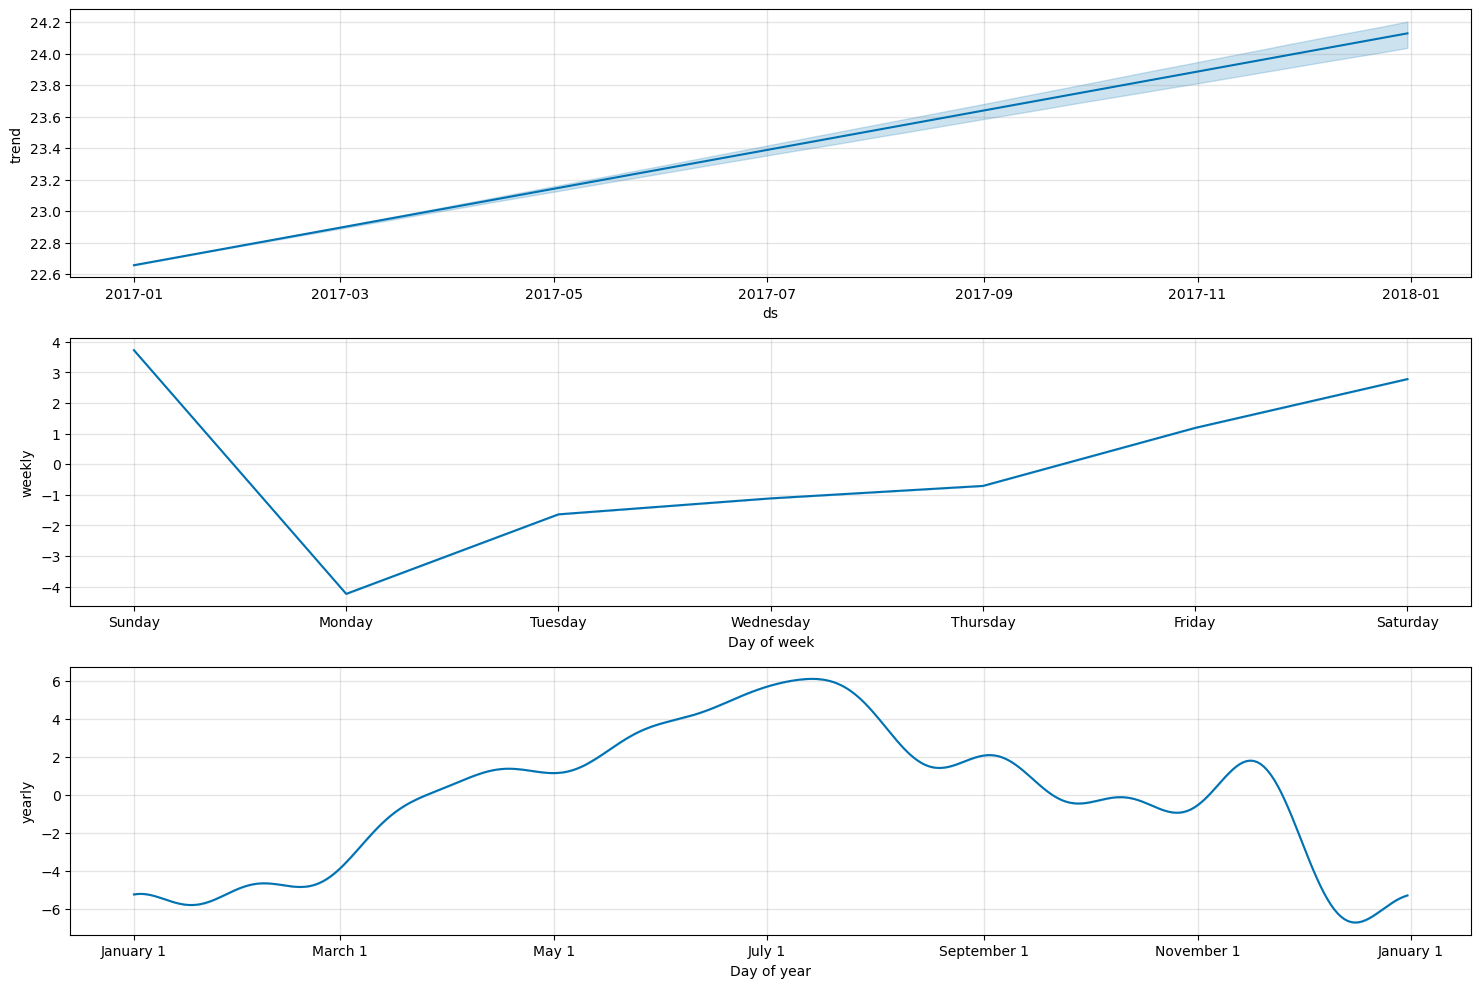

In [25]:
prophet_model.plot_components(y_prophet_forecast, figsize=(15, 10))
plt.show()

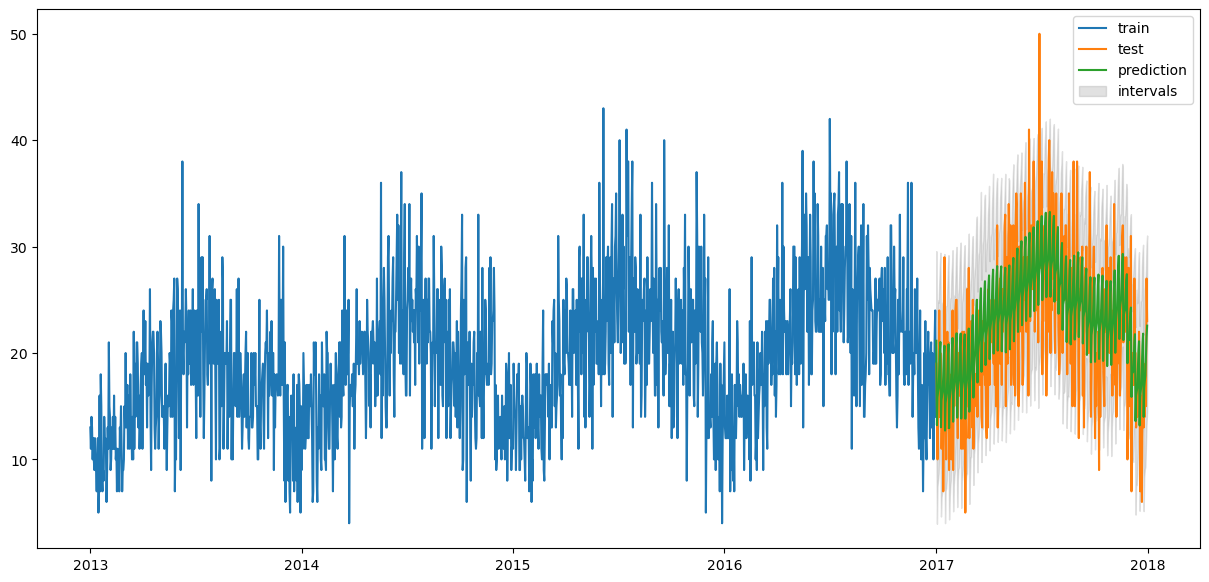

In [27]:
plot_results(data_train, data_test, y_prophet_forecast['yhat'], plot_conf_int=True,
             left_bound=y_prophet_forecast['yhat_lower'],
             right_bound=y_prophet_forecast['yhat_upper'])

In [29]:
compare_table = add_method_comparison('Prophet', data_test, y_prophet_forecast['yhat'])
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.681247,4.032164,22.234031


#### **Задание**
- Обучите модель Prophet с учётом праздников США — *Prophet + US holidays*.
- Преобразование Бокса — Кокса: обучите модель Prophet на преобразованном таргете — *Prophet*:
    - сделайте прямое преобразование над таргетом sps.boxcox(y);
    - потом сделайте обратное (нужно написать самостоятельно).

In [63]:
holidays = pd.read_csv('US holidays all.csv', parse_dates=['ds'])
holidays

,holiday,ds,lower_window,upper_window
0,us_holiday,2013-01-01,0,1
1,us_holiday,2013-01-05,0,1
2,us_holiday,2013-01-06,0,1
3,us_holiday,2013-01-12,0,1
4,us_holiday,2013-01-13,0,1
...,...,...,...,...
676,us_holiday,2018-12-22,0,1
677,us_holiday,2018-12-23,0,1
678,us_holiday,2018-12-25,0,1
679,us_holiday,2018-12-29,0,1


In [ ]:
Prophet().seasonality_prior_scale

### 4.2. Prophet + US holidays

08:33:57 - cmdstanpy - INFO - Chain [1] start processing
08:33:57 - cmdstanpy - INFO - Chain [1] done processing


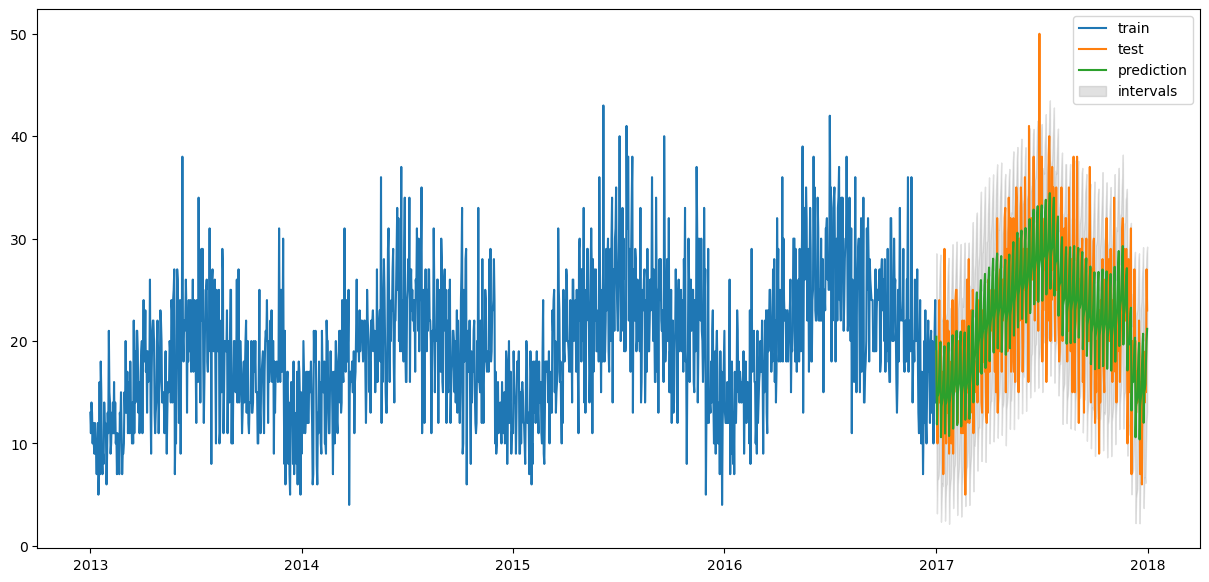

,method,MSE,MAE,MAPE
0,Prophet,24.681247,4.032164,22.234031
1,Prophet + US holidays,23.067975,3.868083,20.263971


In [85]:
#todo
prophet_model = Prophet(interval_width=0.95, holidays=holidays, holidays_prior_scale=100, seasonality_mode='multiplicative',
                       yearly_seasonality=12, changepoint_prior_scale=0.39)


prophet_model.fit(prophet_train_df)

future = prophet_model.make_future_dataframe(
    periods=test_size, include_history=False
)

y_prophet_forecast = prophet_model.predict(future)

plot_results(data_train, data_test, y_prophet_forecast['yhat'], plot_conf_int=True,
             left_bound=y_prophet_forecast['yhat_lower'],
             right_bound=y_prophet_forecast['yhat_upper'])
compare_table = add_method_comparison('Prophet + US holidays', data_test, y_prophet_forecast['yhat'], compare_table)
compare_table

In [ ]:
 , 
                        

### 4.3. Prophet. Преобразование Бокса — Кокса

10:53:25 - cmdstanpy - INFO - Chain [1] start processing
10:53:26 - cmdstanpy - INFO - Chain [1] done processing


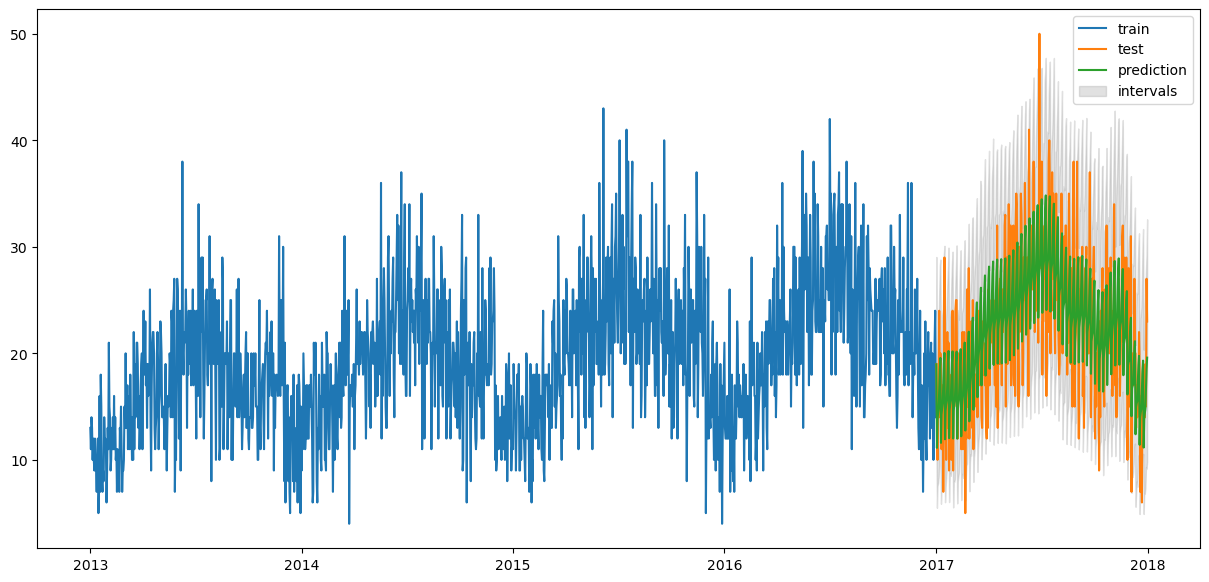

,method,MSE,MAE,MAPE
0,Prophet,24.681247,4.032164,22.234031
1,Prophet + US holidays,23.067975,3.868083,20.263971
2,Prophet + Box-Cox,23.213181,3.909647,20.576081


In [219]:
#todo
# Преобразование Бокса-Кокса
prophet_train_df_boxcox = prophet_train_df.copy()
prophet_train_df_boxcox['y'] = stats.boxcox(prophet_train_df['y'])[0]


prophet_model = Prophet(interval_width=0.95, changepoint_prior_scale= 0.27,
                         holidays = None,                       
                         changepoint_range=0.89,
                         daily_seasonality=16,
                         holidays_prior_scale=52.1,
                         seasonality_mode='multiplicative',
                         weekly_seasonality=19,
                         yearly_seasonality=7)

prophet_model.fit(prophet_train_df_boxcox)

future = prophet_model.make_future_dataframe(
    periods=test_size, include_history=False
)

y_prophet_forecast = prophet_model.predict(future)

# Обратное преобразование Бокса-Кокса
lambda_boxcox = stats.boxcox(prophet_train_df['y'])[1]
y_restored = pd.DataFrame()
if lambda_boxcox == 0:
    y_restored = y_prophet_forecast.apply(np.exp)
else:
    y_restored['yhat'] = inv_boxcox(y_prophet_forecast['yhat'], lambda_boxcox)
    y_restored['yhat_lower'] = inv_boxcox(y_prophet_forecast['yhat_lower'], lambda_boxcox)
    y_restored['yhat_upper'] = inv_boxcox(y_prophet_forecast['yhat_upper'], lambda_boxcox)

plot_results(data_train, data_test, y_restored['yhat'], plot_conf_int=True,
             left_bound=y_restored['yhat_lower'],
             right_bound=y_restored['yhat_upper'])
compare_table = add_method_comparison('Prophet + Box-Cox', data_test, y_restored['yhat'], compare_table)
compare_table

In [221]:

from sklearn.metrics import mean_absolute_percentage_error
from hyperopt import fmin, tpe, hp, Trials

param_space = {
    'seasonality_mode': hp.choice('seasonality_mode', ['multiplicative', 'additive']),
    'holidays' : hp.choice('holidays', [holidays, None]),
    'yearly_seasonality' : hp.choice('yearly_seasonality', list(range(1,20,1))),
    'weekly_seasonality' : hp.choice('weekly_seasonality', list(range(1,20,1))),
    'daily_seasonality' : hp.choice('daily_seasonality', list(range(1,20,1))),
    'changepoint_prior_scale' : hp.choice('changepoint_prior_scale', np.arange(0.01, 1, 0.02)),
    'holidays_prior_scale': hp.choice('holidays_prior_scale', np.arange(0.1, 100, 0.1)),
    'changepoint_range': hp.choice('changepoint_range', np.arange(0.01, 1, 0.01)),
    'seasonality_prior_scale': hp.choice('seasonality_prior_scale', np.arange(0.1, 100, 0.1)),
    
}

def obj_fnc(params):

  model = Prophet(**params)
    
  

  MAPE = mean_absolute_percentage_error(y_true=data_test, y_pred=y_restored['yhat'])
  return -1*MAPE

trials = Trials()
best_params = fmin(obj_fnc, space=param_space, algo=tpe.suggest, max_evals=100,
                   trials=trials, show_progressbar=True)

100%|████████████████████████████████████████████| 100/100 [00:30<00:00,  3.33trial/s, best loss: -0.20576080626886958]


In [223]:
from hyperopt import space_eval
res_params = space_eval(param_space, trials.argmin)
res_params

{'changepoint_prior_scale': 0.20999999999999996,
 'changepoint_range': 0.22,
 'daily_seasonality': 11,
 'holidays':         holiday         ds  lower_window  upper_window
 0    us_holiday 2013-01-01             0             1
 1    us_holiday 2013-01-05             0             1
 2    us_holiday 2013-01-06             0             1
 3    us_holiday 2013-01-12             0             1
 4    us_holiday 2013-01-13             0             1
 ..          ...        ...           ...           ...
 676  us_holiday 2018-12-22             0             1
 677  us_holiday 2018-12-23             0             1
 678  us_holiday 2018-12-25             0             1
 679  us_holiday 2018-12-29             0             1
 680  us_holiday 2018-12-30             0             1
 
 [681 rows x 4 columns],
 'holidays_prior_scale': 52.800000000000004,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 61.300000000000004,
 'weekly_seasonality': 11,
 'yearly_seasonality': 7}

### 5. AutoARIMA [without exog]

### 5.1. AutoARIMA [without exog]

In [231]:
arima_model = auto_arima(data_train, seasonal=True, m = 7)

In [233]:
y_arima_forecast, conf_int = arima_model.predict(n_periods=test_size, return_conf_int=True, alpha=0.05)

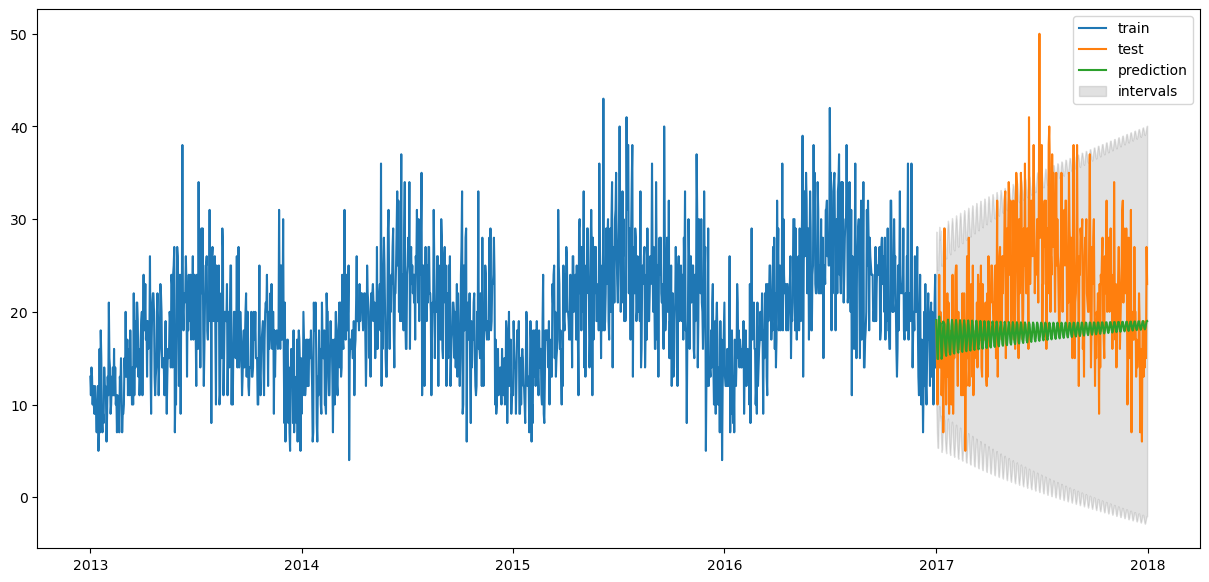

In [235]:
plot_results(data_train, data_test, y_arima_forecast, plot_conf_int=True,
             left_bound=conf_int.T[0],
             right_bound=conf_int.T[1])

In [237]:
compare_table = add_method_comparison('Auto arima model', data_test, y_arima_forecast, compare_table)
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.681247,4.032164,22.234031
1,Prophet + US holidays,23.067975,3.868083,20.263971
2,Prophet + Box-Cox,23.213181,3.909647,20.576081
3,Auto arima model exog,34.980364,4.742038,27.022426
4,Auto arima model,63.698148,6.258276,27.869783


### 5.2. AutoARIMA exog

In [227]:
exog = pd.DataFrame({'date': data.index})
exog = exog.set_index(exog['date'])

exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)

exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)

exog = exog.drop(columns=['date'])

exog_to_train = exog.iloc[:-test_size]
exog_to_test = exog.iloc[-test_size:]

In [71]:
data_train

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
              ..
2016-12-27    10
2016-12-28    16
2016-12-29    21
2016-12-30    24
2016-12-31    14
Name: sales, Length: 1461, dtype: int64

todo: используйте модель `auto_arima` с экзогенными переменными, которые созданы выше (их не надо менять).

Посчитайте метрики качества и добавьте их в датафрейм (сравнительную таблицу) с метриками по всем обученным до этого моделям.

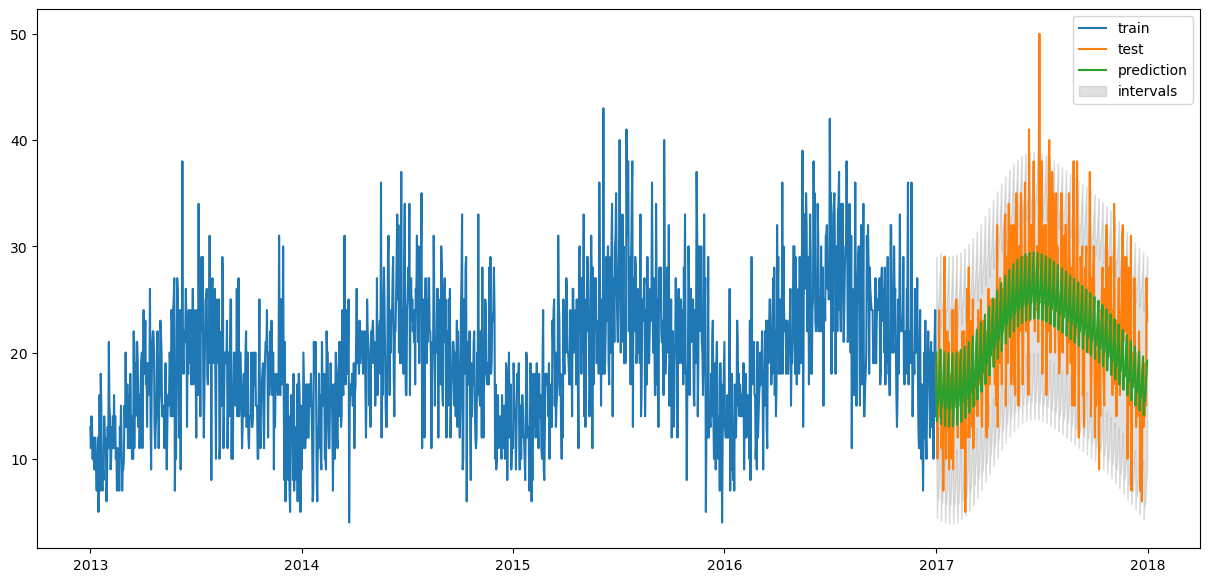

,method,MSE,MAE,MAPE
0,Prophet,24.681247,4.032164,22.234031
1,Prophet + US holidays,23.067975,3.868083,20.263971
2,Prophet + Box-Cox,23.213181,3.909647,20.576081
3,Auto arima model,63.698148,6.258276,27.869783
4,Original SARIMAX,70.897410,6.652360,28.889465
5,Exog SARIMAX,24.865784,3.947291,19.609285
6,Auto arima model exog,25.682066,3.998562,20.235779


In [407]:
#to do
arima_model = auto_arima(data_train, exog_to_train, seasonal=True, n_jobs=4, stepwise = False, with_intercept=True, p=1, q=0, d=0, 
                         m=7, maxiter=100, n_fits=20)
y_arima_forecast, conf_int = arima_model.predict(n_periods=test_size, X=exog_to_test, return_conf_int=True, alpha=0.05)
plot_results(data_train, data_test, y_arima_forecast, plot_conf_int=True,
             left_bound=conf_int.T[0],
             right_bound=conf_int.T[1])
compare_table = add_method_comparison('Auto arima model exog', data_test, y_arima_forecast, compare_table)
compare_table


In [277]:
arima_model.get_params

<bound method BaseEstimator.get_params of ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 0, 2, 7),
      suppress_warnings=True)>

### 6. SARIMAX [without exog]

### 6.1. SARIMAX [without exog]

In [409]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# передаем параметры из прошлой модели
real_sarimax_model = SARIMAX(data_train, order=(3, 1, 5), seasonal_order=(0, 0, 2, 7),
    seasonal_periods=7,
    ).fit()


C:\Users\Msi-1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Msi-1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Msi-1\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\Msi-1\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [410]:
forecast = real_sarimax_model.get_forecast(steps=len(data_test))
y_sarimax_real_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()


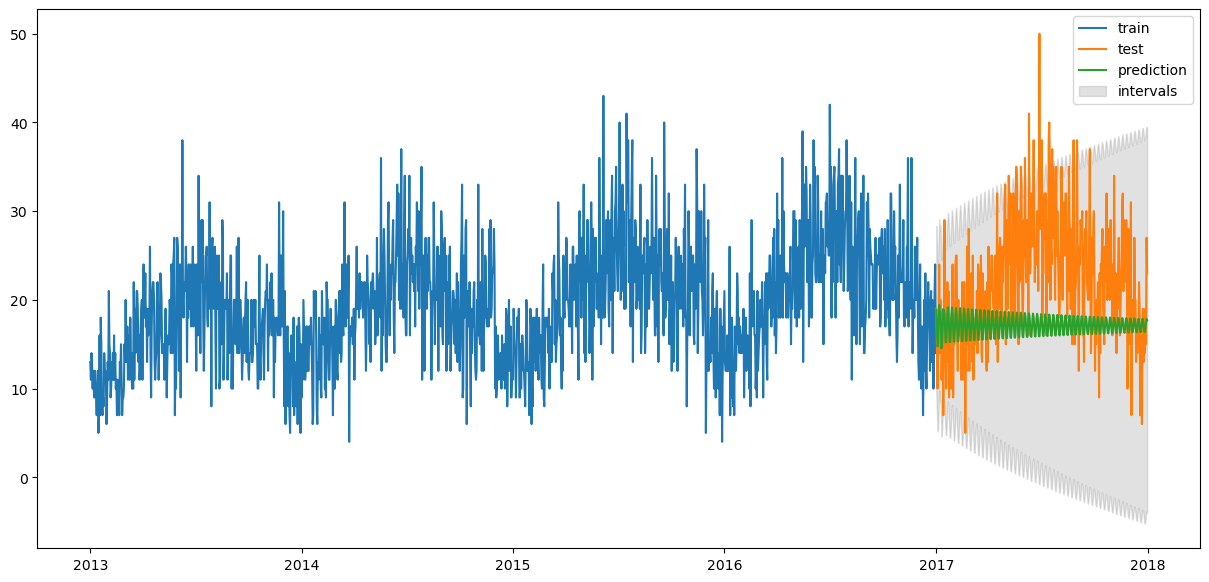

In [411]:
plot_results(data_train, data_test,
             y_sarimax_real_forecast, plot_conf_int=True,
             left_bound=conf_int['lower sales'], right_bound=conf_int['upper sales'])

In [415]:
compare_table = add_method_comparison('Original SARIMAX', data_test, y_sarimax_real_forecast, compare_table)
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.681247,4.032164,22.234031
1,Prophet + US holidays,23.067975,3.868083,20.263971
2,Prophet + Box-Cox,23.213181,3.909647,20.576081
3,Auto arima model,63.698148,6.258276,27.869783
4,Exog SARIMAX,24.865784,3.947291,19.609285
5,Auto arima model exog,25.682066,3.998562,20.235779
6,Original SARIMAX,70.897410,6.652360,28.889465


### 6.2. SARIMAX with exog

In [417]:
exog = pd.DataFrame({'date': data.index})
exog = exog.set_index(exog['date'])

exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)

exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)

exog = exog.drop(columns=['date'])

exog_to_train = exog.iloc[:-test_size]
exog_to_test = exog.iloc[-test_size:]

todo: используйте модель `SARIMAX` с экзогенными переменными, которые созданы выше (их не надо менять), для улучшения предсказаний.

C:\Users\Msi-1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Msi-1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Msi-1\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\Msi-1\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Msi-1\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\represen

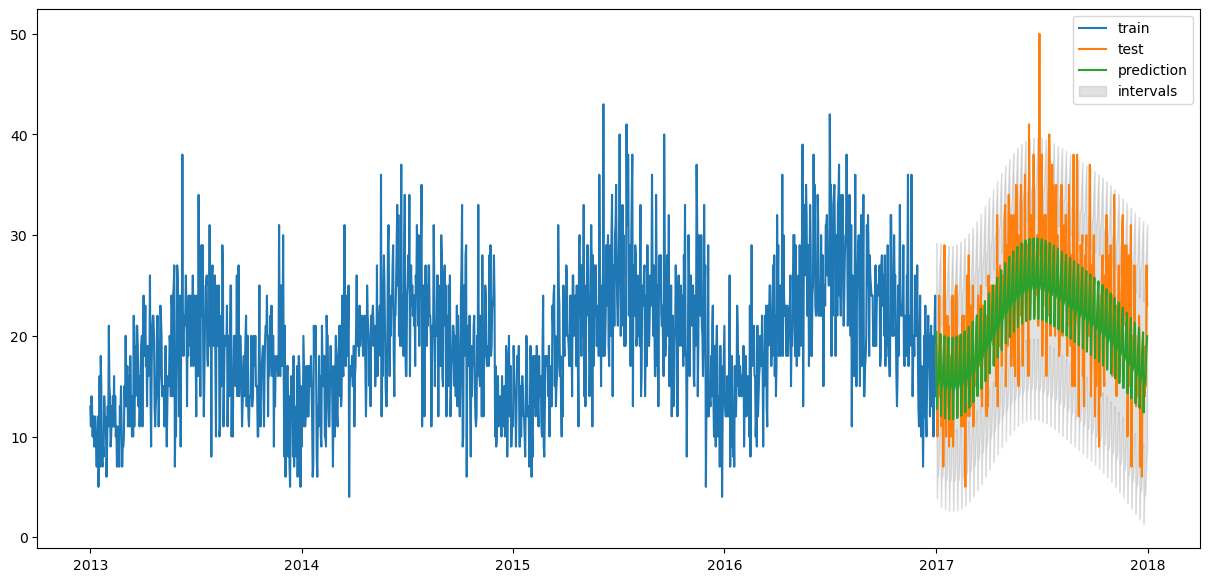

,method,MSE,MAE,MAPE
0,Prophet,24.681247,4.032164,22.234031
1,Prophet + US holidays,23.067975,3.868083,20.263971
2,Prophet + Box-Cox,23.213181,3.909647,20.576081
3,Auto arima model,63.698148,6.258276,27.869783
4,Auto arima model exog,25.682066,3.998562,20.235779
5,Original SARIMAX,70.897410,6.652360,28.889465
6,Exog SARIMAX,24.865784,3.947291,19.609285


In [419]:
#to do
real_sarimax_model = SARIMAX(data_train, exog_to_train, order=(1, 0, 5), seasonal_order=(1, 0, 2, 7),
    seasonal_periods=7,
    ).fit()
forecast = real_sarimax_model.get_forecast(steps=len(data_test), exog=exog_to_test)
y_sarimax_real_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()
plot_results(data_train, data_test,
             y_sarimax_real_forecast, plot_conf_int=True,
             left_bound=conf_int['lower sales'], right_bound=conf_int['upper sales'])
compare_table = add_method_comparison('Exog SARIMAX', data_test, y_sarimax_real_forecast, compare_table)
compare_table

### 7. TBATS

Модель учитывает несколько сезонностей, но не может принимать экзогенные признаки.

In [455]:
tbats_estimator = TBATS(seasonal_periods=(7,365), use_box_cox=True, n_jobs=4)
model = tbats_estimator.fit(data_train)

In [123]:
print(model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7. 180.]
Seasonal harmonics [3 3]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.099254
Seasonal Parameters (Gamma): [ 0.00073055  0.00126939 -0.00168362 -0.00071569]
AR coefficients []
MA coefficients []
Seed vector [11.64783078 -2.63361686 -0.19728629  1.19371923 -0.73577877  1.77368199
  0.93247816  0.28014787 -0.22456824 -0.7175311  -0.93148604 -0.02311377
  0.1540708 ]

AIC 15098.062904


In [447]:
tbats_forecast, confidence_info = model.forecast(steps=365, confidence_level=0.95)

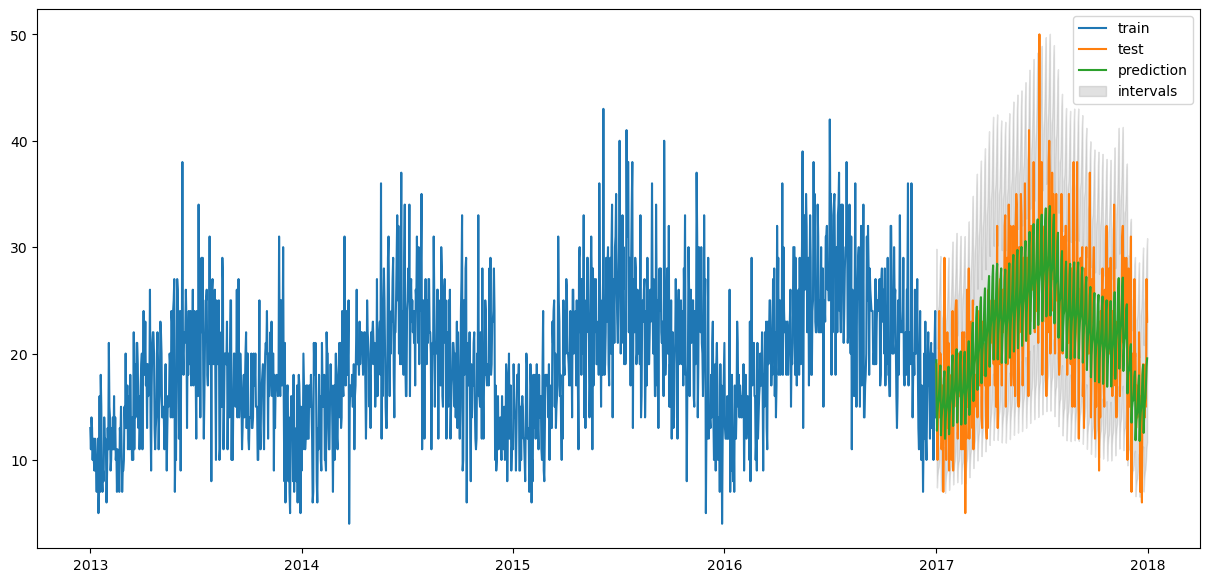

In [449]:
plot_results(data_train, data_test, tbats_forecast, plot_conf_int=True,
             left_bound=confidence_info['lower_bound'],
             right_bound=confidence_info['upper_bound'])

In [451]:
compare_table = add_method_comparison('TBATS model', data_test, tbats_forecast, compare_table)

In [453]:
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.681247,4.032164,22.234031
1,Prophet + US holidays,23.067975,3.868083,20.263971
2,Prophet + Box-Cox,23.213181,3.909647,20.576081
3,Auto arima model,63.698148,6.258276,27.869783
4,Auto arima model exog,25.682066,3.998562,20.235779
5,Original SARIMAX,70.897410,6.652360,28.889465
6,Exog SARIMAX,24.865784,3.947291,19.609285
7,TBATS model,22.974805,3.831477,19.828138


### 8. ИТОГО

todo:
- Опишите, что вы сделали в этой работе, какие параметры моделей подбирали и как.
- Сравните модели между собой и проанализируйте результаты.
- Выберите лучшую модель.

Метрика MAPE, которую нужно достичь (достаточно правильной настройки гиперпараметров моделей), должна быть менее 20%.

In [443]:
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.681247,4.032164,22.234031
1,Prophet + US holidays,23.067975,3.868083,20.263971
2,Prophet + Box-Cox,23.213181,3.909647,20.576081
3,Auto arima model,63.698148,6.258276,27.869783
4,Auto arima model exog,25.682066,3.998562,20.235779
5,Original SARIMAX,70.897410,6.652360,28.889465
6,Exog SARIMAX,24.865784,3.947291,19.609285
7,TBATS model,22.974805,3.831477,19.828138


Лучше всего отработали модели SARIMAX и TBATS, при этом SARIMAX оказался значительно быстрее. Добиться порога MAPE<20 для моделей Prophet и Auto ARIMA 
не удалось, праdда в задании четко не прописано, что метрика должна быть меньше 20 для всех моделей. Добавление экзогенных признаков в основном улучшает метрики модели. Также важное значение имеет определение правильной сезонности и тренда.